# MaterialPointSolver.jl Showcase 02

Author: Zenan Huo <br>
Date: 25-Aug-2024 <br>

---

This case is the 3D soil collapse test in MPM. You can compare to showcase 01 to see the differences.

In [1]:
using MaterialPointSolver
using KernelAbstractions
using CairoMakie
using CUDA

In [2]:
warmup(Val(:CUDA)) # optional

[ Info: code warm-up, wait a moment 🔥


In [3]:
rtsdir     = joinpath(@__DIR__, "outputs")
assetsdir  = MaterialPointSolver.assets_dir
figregular = MaterialPointSolver.tnr
figbold    = MaterialPointSolver.tnrb

init_grid_space_x = 0.0025
init_grid_space_y = 0.0025
init_grid_space_z = 0.0025
init_grid_range_x = [-0.02, 0.07]
init_grid_range_y = [-0.02, 0.55]
init_grid_range_z = [-0.02, 0.12]
init_mp_in_space  = 2
init_project_name = "3d_collapse"
init_project_path = joinpath(rtsdir, init_project_name)
init_constitutive = :druckerprager
init_gravity      = -9.8
init_ζs           = 0
init_ρs           = 2700
init_ν            = 0
init_E            = 1e6
init_Ks           = init_E/(3*(1-2*init_ν))
init_G            = init_E/(2*(1+  init_ν))
init_T            = 1
init_Te           = 0
init_ΔT           = 0.5 * init_grid_space_x / sqrt((init_Ks + 4/3 * init_G) / init_ρs)
init_step         = (t = floor(init_T / init_ΔT / 10); t<10 ? 1 : t)
init_σt           = 0
init_ϕ            = 19.8*π/180
init_c            = 0
init_ψ            = 0
init_basis        = :uGIMP
init_phase        = 1
init_NIC          = 64
iInt              = Int64
iFloat            = Float64;

### Parameters Setup

In [4]:
args = Args3D{iInt, iFloat}(
    Ttol         = init_T,
    ΔT           = init_ΔT,
    Te           = init_Te,
    time_step    = :fixed,
    FLIP         = 1,
    PIC          = 0,
    ζs           = init_ζs,
    gravity      = init_gravity,
    project_name = init_project_name,
    project_path = init_project_path,
    constitutive = init_constitutive,
    animation    = false,
    hdf5         = false,
    hdf5_step    = init_step,
    MVL          = true,
    device       = :CUDA,
    coupling     = :OS,
    progressbar  = true,
    basis        = init_basis
)

Args3D{Int64, Float64}
──────────────────────
project name    : 3d_collapse
project path    : /home/zhuo/Workbench/MaterialPointSolver.jl/examples/outputs/3d_collapse
precision       : FP64
constitutive    : druckerprager
basis method    : uGIMP
mitigate vollock: true
coupling scheme : OS


### Background Grid Setup

In [5]:
grid = Grid3D{iInt, iFloat}(
    NIC      = init_NIC,
    range_x1 = init_grid_range_x[1],
    range_x2 = init_grid_range_x[2],
    range_y1 = init_grid_range_y[1],
    range_y2 = init_grid_range_y[2],
    range_z1 = init_grid_range_z[1],
    range_z2 = init_grid_range_z[2],
    space_x  = init_grid_space_x,
    space_y  = init_grid_space_y,
    space_z  = init_grid_space_z,
    phase    = init_phase
)

Grid3D{Int64, Float64}
──────────────────────
node: 482961
cell: 459648


### Material Points Setup

In [6]:
space_x = grid.space_x / init_mp_in_space
space_y = grid.space_y / init_mp_in_space
space_z = grid.space_z / init_mp_in_space
x_tmp, y_tmp, z_tmp = meshbuilder(0 + space_x / 2 : space_x : 0.05 - space_x / 2,
                                  0 + space_y / 2 : space_y : 0.20 - space_y / 2,
                                  0 + space_z / 2 : space_z : 0.10 - space_z / 2)
mp_num = length(x_tmp)
mp_ρs  = ones(mp_num).*init_ρs
mp     = Particle3D{iInt, iFloat}(space_x=space_x, space_y=space_y, space_z=space_z,
    pos=[x_tmp y_tmp z_tmp], ρs=mp_ρs, NIC=init_NIC, phase=init_phase)

Particle3D{Int64, Float64}
──────────────────────────
particle: 512000


### Particle Property Setup

In [7]:
mp_layer   = ones(mp_num)
mp_ν       = [init_ν]
mp_E       = [init_E]
mp_G       = [init_G]
mp_σt      = [init_σt]
mp_ϕ       = [init_ϕ]
mp_c       = [init_c]
mp_ψ       = [init_ψ]
mp_Ks      = [init_Ks]
pts_attr   = ParticleProperty{iInt, iFloat}(layer=mp_layer, ν=mp_ν, E=mp_E, G=mp_G, 
    σt=mp_σt, ϕ=mp_ϕ, c=mp_c, ψ=mp_ψ, Ks=mp_Ks)

ParticleProperty{Int64, Float64}
────────────────────────────────
material partition: 1


### Boundary Condition Nodes Index

In [8]:
vx_idx  = zeros(iInt, grid.node_num)
vy_idx  = zeros(iInt, grid.node_num)
vz_idx  = zeros(iInt, grid.node_num)
tmp_idx = findall(i -> grid.pos[i, 1] ≤ 0 || grid.pos[i, 1] ≥ 0.05 ||
                       grid.pos[i, 3] ≤ 0 || grid.pos[i, 2] ≤ 0, 1:grid.node_num)
tmp_idy = findall(i -> grid.pos[i, 2] ≤ 0 || grid.pos[i, 3] ≤ 0, 1:grid.node_num)
tmp_idz = findall(i -> grid.pos[i, 3] ≤ 0, 1:grid.node_num)
vx_idx[tmp_idx] .= 1
vy_idx[tmp_idy] .= 1
vz_idx[tmp_idz] .= 1
bc = VBoundary3D{iInt, iFloat}(
    Vx_s_Idx = vx_idx,
    Vx_s_Val = zeros(grid.node_num),
    Vy_s_Idx = vy_idx,
    Vy_s_Val = zeros(grid.node_num),
    Vz_s_Idx = vz_idx,
    Vz_s_Val = zeros(grid.node_num)
)

VBoundary3D{Int64, Float64}
───────────────────────────
velocity boundary


### MPM Solver

In [9]:
materialpointsolver!(args, grid, mp, pts_attr, bc)

┌ Info: 3d_collapse [3D/CUDA]
│ ────────────────┬─────────────┬─────────────────
│ ΔT  : 6.50e-05s │ PIC :  0.00 │ scheme   : MUSL
│ Ttol: 1.00e+00s │ FLIP:  1.00 │ coupling : OS
│ pts : 5.12e+05  │ ζs  :  0.00 │ animation: false
│ nds : 4.83e+05  │ ζw  :  0.00 │ precision: FP64
│ MVL :     true  │ HDF5: false │ material : D-P
└ ────────────────┴─────────────┴─────────────────


[▲ I/O: host [≈ 1.5 GiB] → device 0 [:CUDA]


[ Info: solving 100% ◼◼◼◼◼◼◼◼◼◼◼◼  Time: 0:03:52


[▼ I/O: device 0 [CUDA] → host
[• I/O: free device 0 memory


┌ Info: performance
│ ─────────────────────
│ wtime: 00:03:53
│ iters: 1.54e+04
│ speed: 6.63e+01  it/s
│ MTeff: 2.14e+02 GiB/s
└ ─────────────────────


### Post processing

* save to `.vtu` for ParaView:

In [10]:
savevtu(args, grid, mp, pts_attr)

[ Info: final vtu file is saved in project path


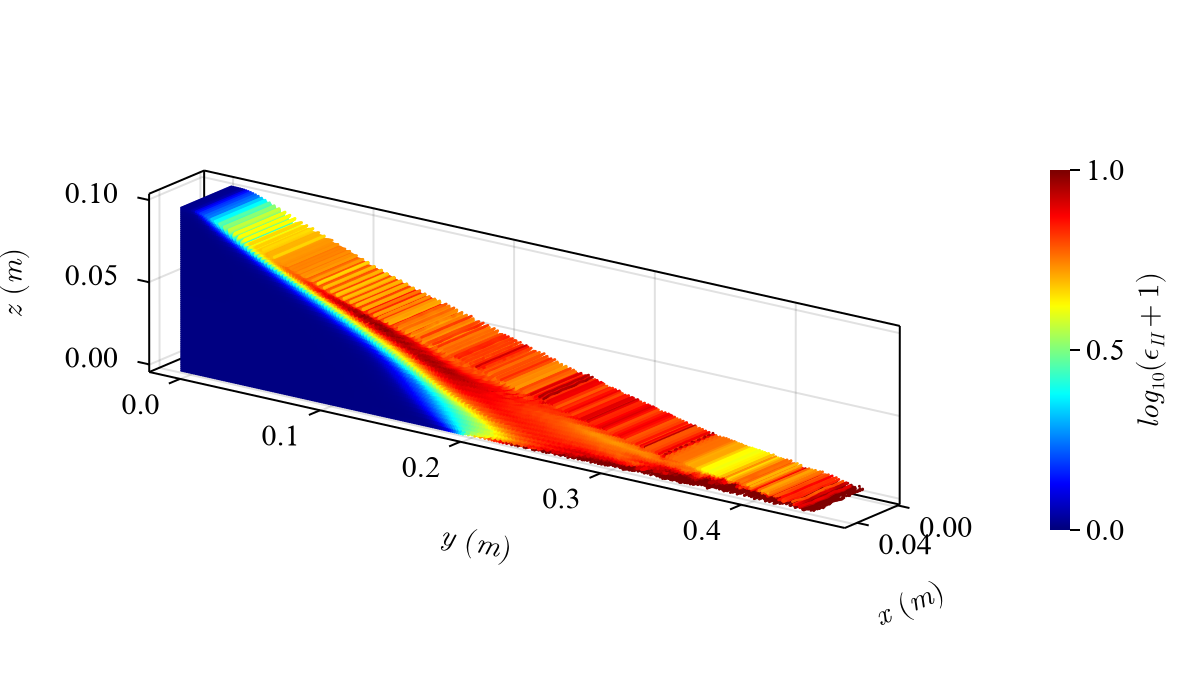

CairoMakie.Screen{IMAGE}


In [11]:
let
    fig = Figure(size=(600, 350), fonts=(; regular=figregular, bold=figbold), fontsize=15)
    ax = Axis3(fig[1, 1], xlabel=L"x\ (m)", ylabel=L"y\ (m)", zlabel=L"z\ (m)", 
        aspect=:data, azimuth=0.2*π, elevation=0.1*π, zlabeloffset=60, xlabeloffset=40, 
        protrusions=50, xticks=(0:0.04:0.04))
    pl1 = scatter!(ax, mp.pos, color=log10.(mp.epII.+1), colormap=:jet, markersize=2,
        colorrange=(0, 1))
    Colorbar(fig[1, 2], limits=(0, 1), colormap=:jet, ticks=0:0.5:1, spinewidth=0,
        label=L"log_{10}(\epsilon_{II}+1)", tellwidth=true, width=10)
    rowsize!(fig.layout, 1, 180)
    display(fig)
end